# Project Info #

- Developed by: Sean Pritchard
- for: CSCA 5622-100: Introduction to Machine Learning: Supervised Learning final project
- URL: https://github.com/seanpritchard94/gone_phishing
- Data Source: https://www.kaggle.com/datasets/mdsultanulislamovi/phishing-website-detection-datasets/data (Ovi, 2025)
- Python version: 3.13


# Supervised Learning Problem Description #


Phishing is a technique where criminals attempt to trick victims into providing personal information, payment information, login credentials and/or other sensitive information which the criminals then use to commit theft and fraud. Phishing often uses email or text messages that direct victims to look-alike sites masquerading as a valid financial institution, merchant, or govenrment agency. These look-alike sites are where the criminals collect sensitive information from victims.

The FBI's *Internet Crime Report 2024* lists phishing/spoofing as the most common internet crime with almost 200,000 complaints. more than double the next most common internet crime of extortion. Losses attributed to phishing/spoofing exceeded $70 million in 2024 alone. (Yarbrough, n.d.).

Automatic detection of such sites is an important part of protecting potential victims from phishing. This project uses data provided by Kaggle (Ovi, 2025) containing features from both phishing and non-phishing sites. This project explores the effectiveness of various machine learning algorithms in predicting phishing sites based on these features.

# EDA Procedure #


There are *many* datasets on Kaggle related to phishing detection. The particular dataset used for this project is dataset 6 from https://www.kaggle.com/datasets/mdsultanulislamovi/phishing-website-detection-datasets/data (Ovi, 2025). Dataset 6 was chosen for several reasons. It is a balanced data set with a reasonable number of features and examples. It contains 48 features plus the label and ID for a total of 50 columns. It contains 10,000 examples balanced between positive and negative cases.

In [85]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
#first we will take a quick look at the data
df = pd.read_csv('data/dataset6.csv')
df.head(10)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
5,6,3,1,1,42,1,0,0,0,0,...,1,1,0,1,1,1,1,-1,1,1
6,7,2,0,5,60,0,0,0,0,0,...,0,0,0,1,0,1,1,-1,-1,1
7,8,1,0,3,30,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
8,9,8,7,2,76,1,1,0,0,0,...,0,0,0,-1,-1,1,1,1,-1,1
9,10,2,0,2,46,0,0,0,0,0,...,0,0,0,1,1,1,1,-1,-1,1


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

A quick look at the data shows a few things. First, the top rows all seem to be the positive case (CLASS_LABEL=1). It is always important to shuffle the data, but it is critical in this case.

All 10,000 records seem to be well-formed with no missing data. All fields are non-null integers or floats.

Next, let's take a look at the distribution of the data with one histogram for each of the columns.



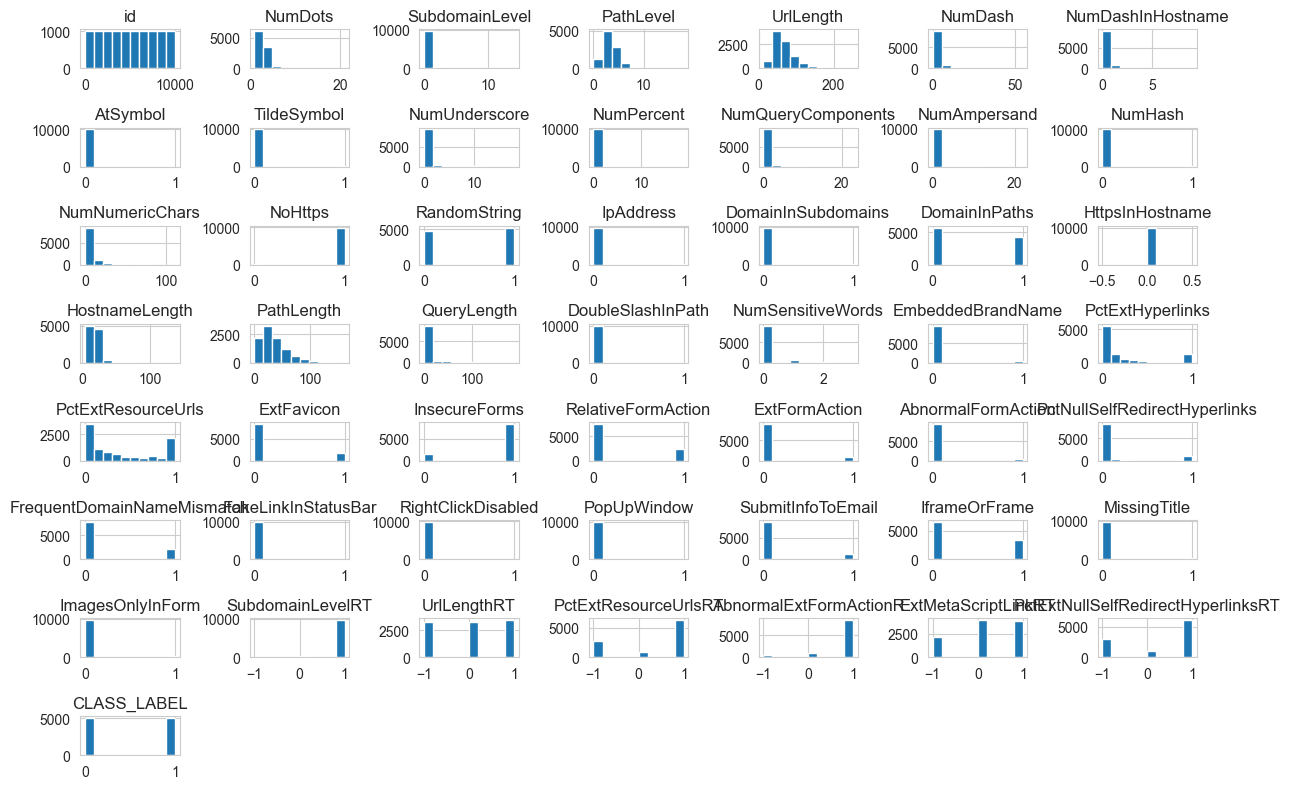

In [10]:
df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

From these histograms, we can see that the scale of the various data fields is significantly different with some fields varying from 1-10 or 1-20 and others running into the hundreds. Also, the values tend to be skewed towards the low end rather than balanced around the mean. Some ML models don't do well with this kinds of data, so we will use scikit learn's StandardScaler to move all fields to a common scale

id is not a useful column, so we will drop that before we go further. We will also examine the correlation between features

In [11]:
df = df.drop(columns = ['id'])

In [12]:
correlation = df.corr()
correlation

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
NumDots,1.000000,0.507992,0.079202,0.277380,-0.198769,0.093034,0.011425,0.109508,0.038068,0.022616,...,-0.117210,0.045291,-0.012244,-0.343927,-0.151756,0.047821,0.032276,0.035586,-0.153835,0.294111
SubdomainLevel,0.507992,1.000000,0.007277,0.098579,-0.050018,0.246368,-0.005845,0.009518,-0.023593,-0.006003,...,-0.001061,0.026432,-0.008830,-0.679687,-0.086943,0.059584,-0.030790,0.093623,-0.034866,0.043132
PathLevel,0.079202,0.007277,1.000000,0.390456,0.090503,0.027626,-0.005891,0.127291,0.015719,-0.043529,...,0.000701,-0.027880,-0.002279,-0.024815,-0.399710,-0.000903,0.040901,0.064222,-0.095786,0.229450
UrlLength,0.277380,0.098579,0.390456,1.000000,0.437313,0.111980,-0.003425,0.058233,0.350756,0.184947,...,0.033192,-0.053222,-0.036766,-0.133533,-0.800096,0.002019,-0.025366,-0.000860,0.142819,-0.074493
NumDash,-0.198769,-0.050018,0.090503,0.437313,1.000000,0.113200,-0.010139,-0.024395,-0.050195,-0.017938,...,0.228154,-0.064450,-0.006314,-0.023363,-0.468798,-0.137093,-0.085238,-0.122579,0.184808,-0.372235
NumDashInHostname,0.093034,0.246368,0.027626,0.111980,0.113200,1.000000,-0.004409,-0.018043,-0.035170,-0.021648,...,0.040743,-0.010096,-0.007712,-0.359595,-0.097446,0.079631,0.038776,0.070111,-0.113745,0.150444
AtSymbol,0.011425,-0.005845,-0.005891,-0.003425,-0.010139,-0.004409,1.000000,-0.001996,-0.005023,0.007226,...,-0.012422,-0.003160,-0.003067,0.003031,-0.007469,-0.006885,-0.004207,0.011307,0.013235,-0.017323
TildeSymbol,0.109508,0.009518,0.127291,0.058233,-0.024395,-0.018043,-0.001996,1.000000,-0.022361,-0.013665,...,-0.039905,-0.011051,-0.020400,0.016614,-0.036087,0.022478,0.022098,0.058519,-0.000144,0.095864
NumUnderscore,0.038068,-0.023593,0.015719,0.350756,-0.050195,-0.035170,-0.005023,-0.022361,1.000000,0.061638,...,-0.010341,-0.019348,-0.019467,0.003353,-0.257480,0.014952,-0.053835,-0.047775,0.100214,-0.098869
NumPercent,0.022616,-0.006003,-0.043529,0.184947,-0.017938,-0.021648,0.007226,-0.013665,0.061638,1.000000,...,-0.021592,-0.011620,-0.006960,0.007147,-0.125811,0.021022,-0.001660,0.018508,0.035300,-0.068465


<Axes: >

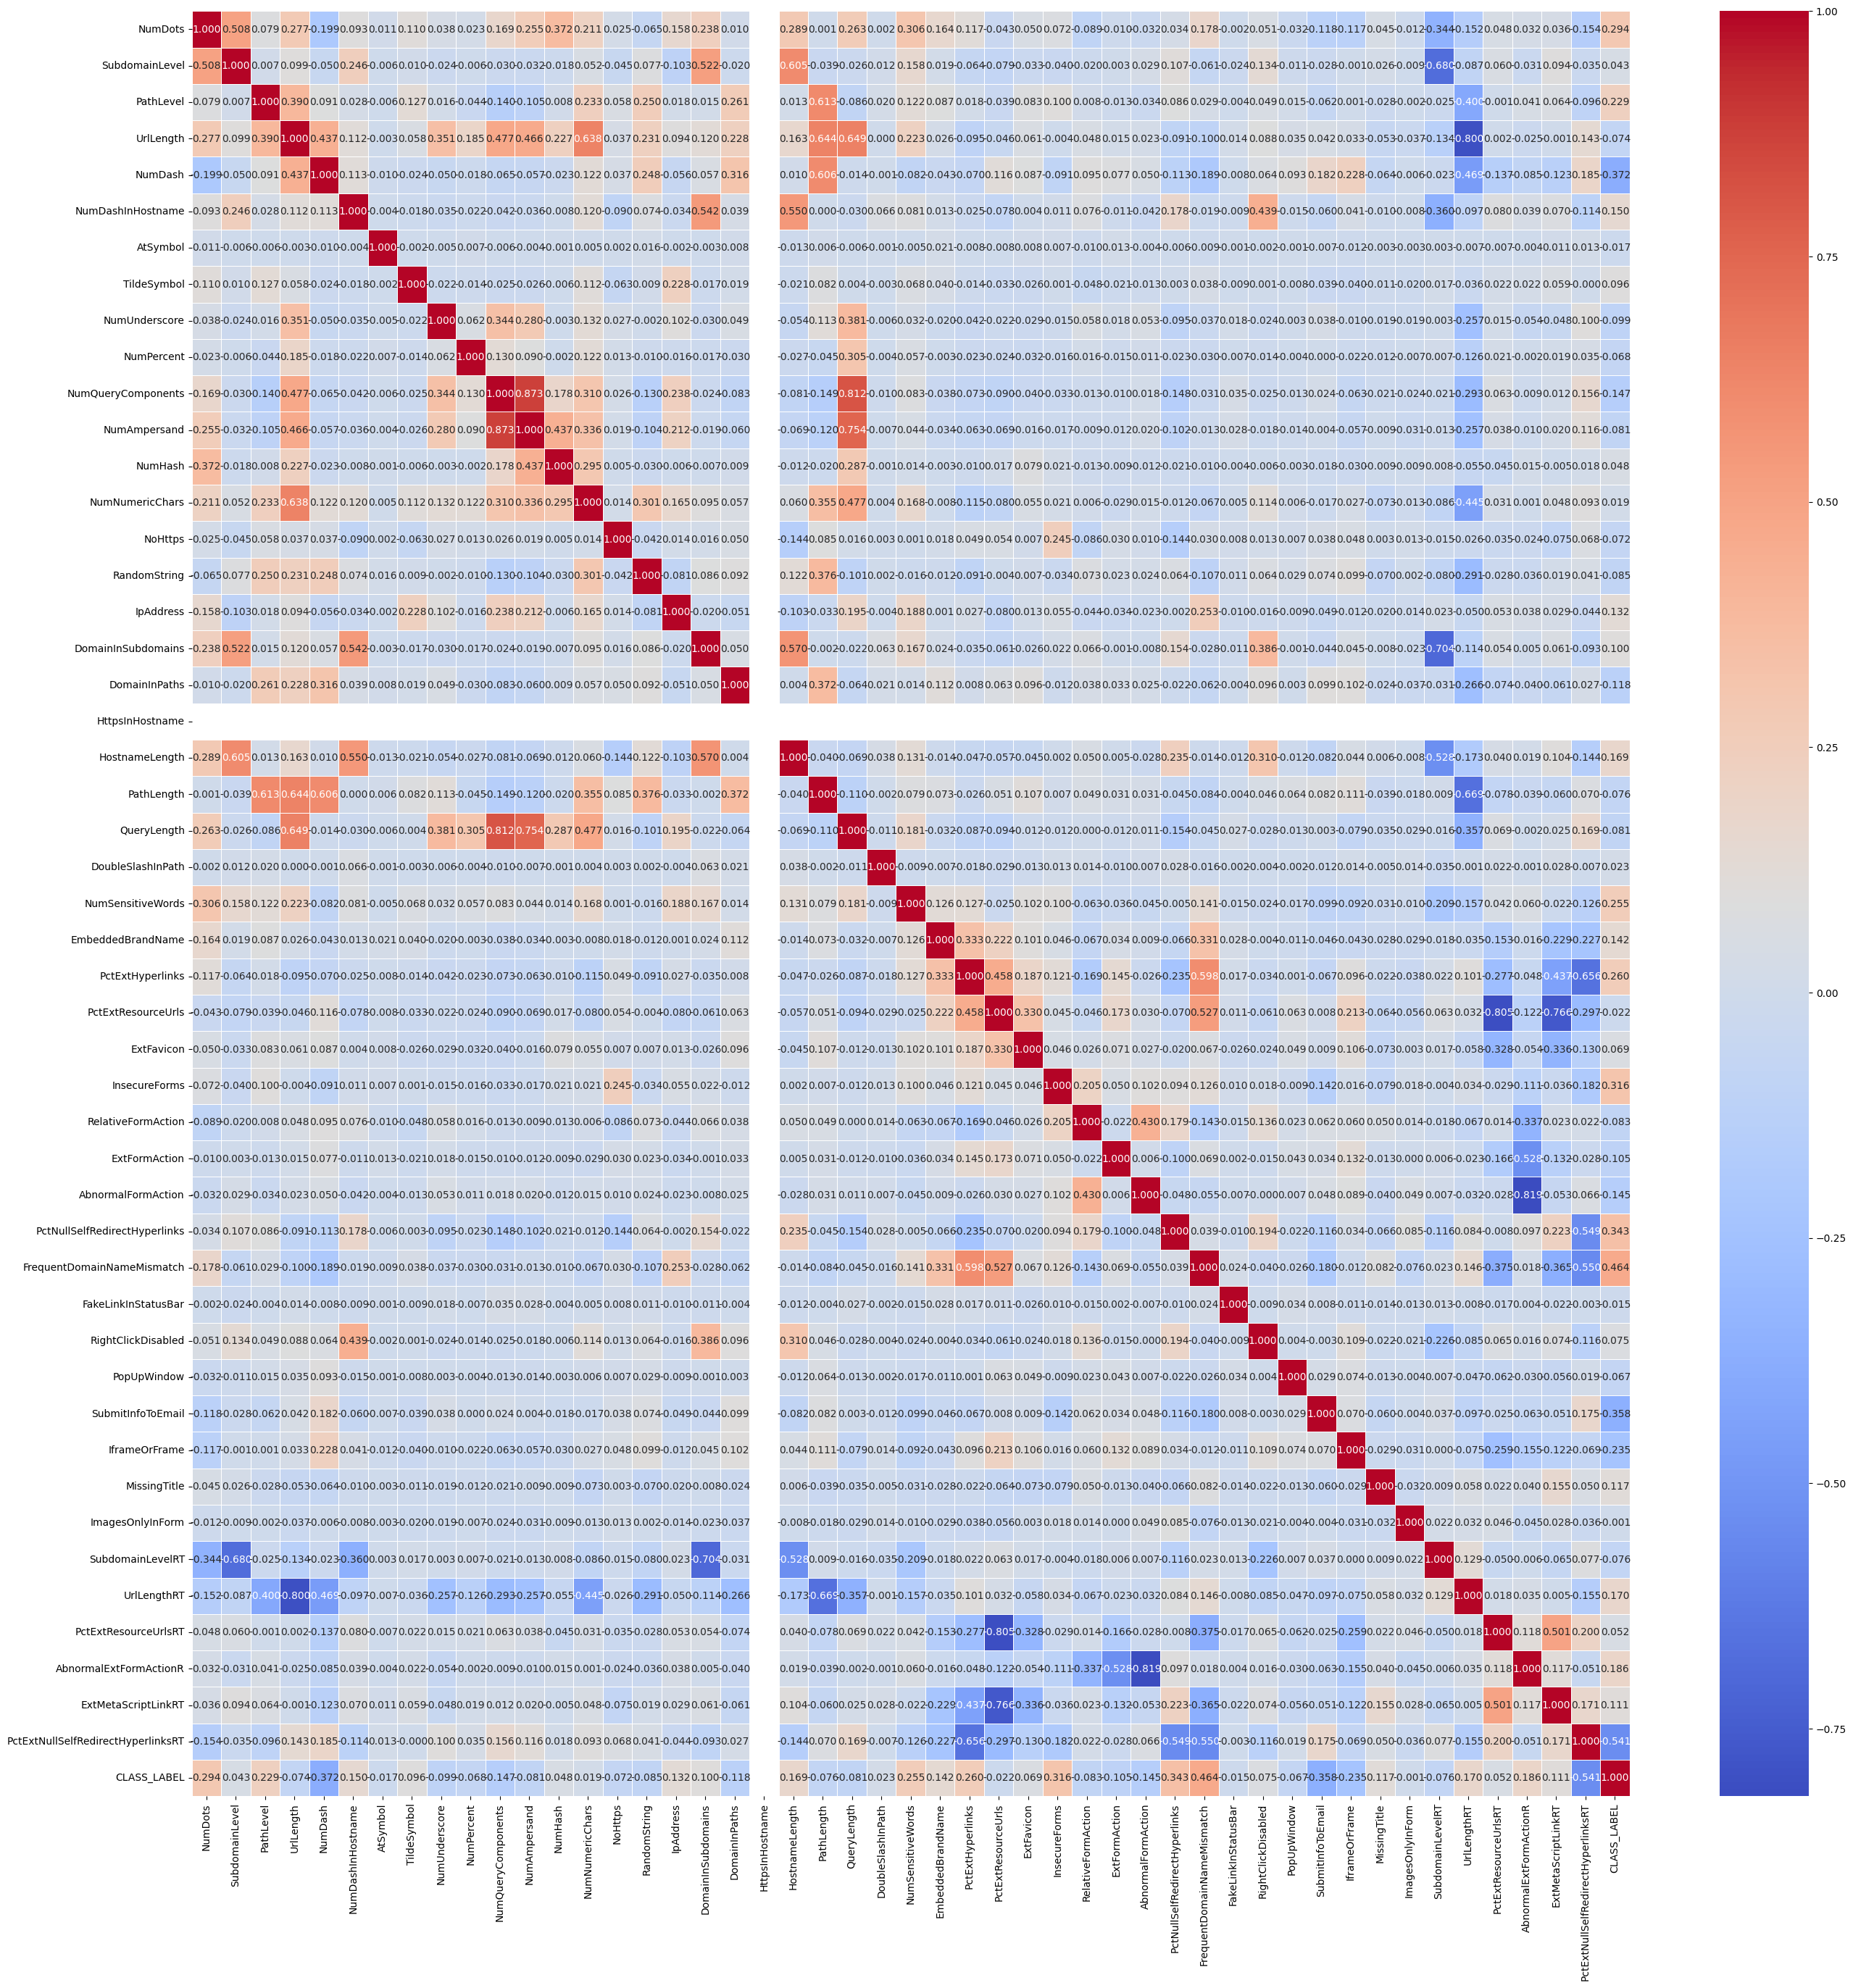

In [17]:
plt.subplots(figsize=(32, 32))
sns.heatmap(correlation, annot=True, fmt=".3f", linewidth=.5, cmap="coolwarm")

The heat map is a bit difficult to read, but if you expand your Jupyter window to your full screen it is a bit more readable. There are some strongly correlated features such as query length, number of query elements, and number of ampersands. These are not particularly surprising. There are several features that more correlated than others with the CLASS_LABEL. These include RequestDomainNameMismatch (0.464), InsecureForms (0.31), SubmitInfoToEmail (-0.358), PctExtNullSelfRedirectHyperlinksRT (-0.541), NumDots (0.294), NumDash (-0.372). But the vast majority of features are not strongly correlated with the class label.

Having completed out EDA, we will now run StandardScaler and split out test and training data.

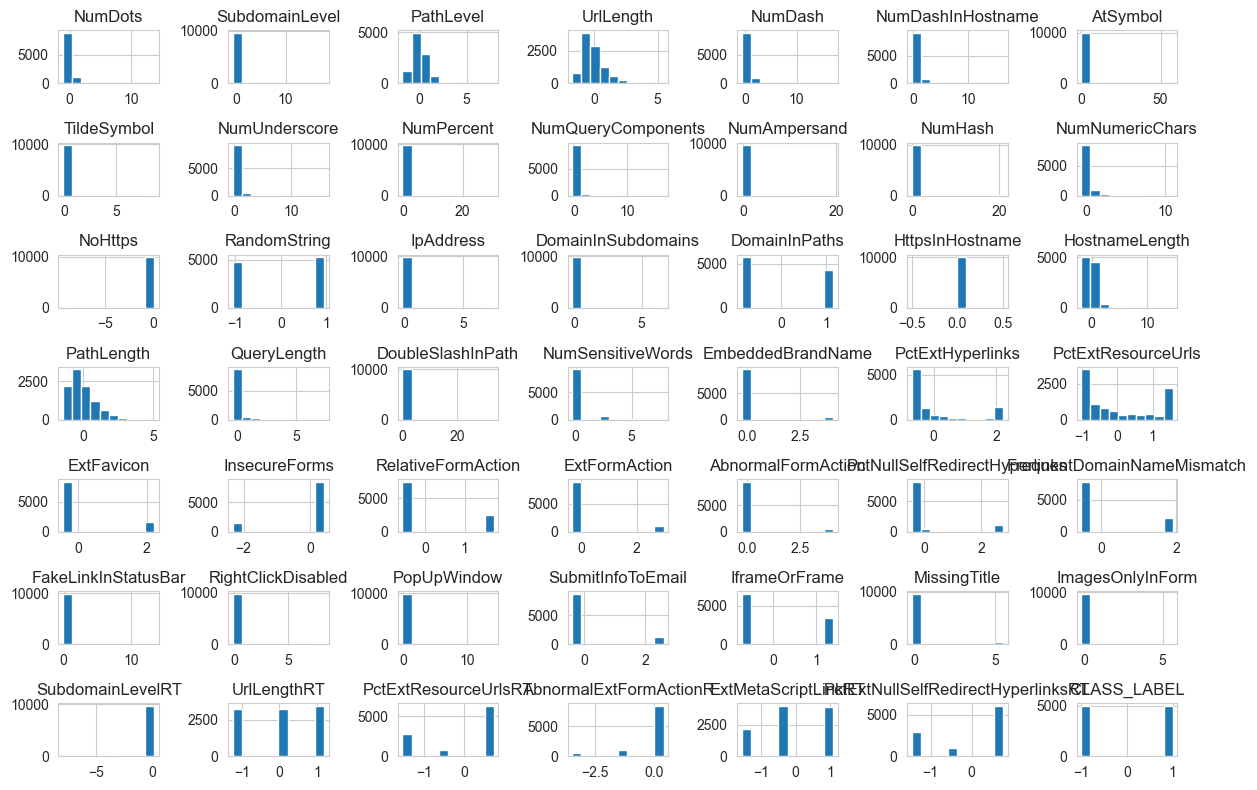

In [13]:
std_scaler = StandardScaler()
scaled = std_scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns)
df_scaled.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

 We can see StandardScaler has scaled the data such that all values are in a more similar range and the values are centered around a mean of 0

## Selecting Test and Train data sets ##

We need to shuffle the data and separate data into test and train sets

In [14]:
shuffled_df = shuffle(df_scaled, random_state=42)
feature_names = shuffled_df.columns.tolist()
y = shuffled_df['CLASS_LABEL'].values
y = np.array(pd.to_numeric(y))
X = shuffled_df.drop('CLASS_LABEL', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Analysis (Model Building and Training) #


## Logistic Regression ##



In [67]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))


              precision    recall  f1-score   support

        -1.0       0.93      0.94      0.94       987
         1.0       0.94      0.93      0.94      1013

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



An f1 of 94% for both classes is not bad at all. But lets try a little bit of hyperparameter tuning along with Cross Fold Validation at the same time to see if we can do a little better. Suggestions for what hyperparameters to tune and what values to try came from a Geeks for Geeks article (GeeksforGeeks, 2025b)

{'max_iter': 2500, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

        -1.0       0.93      0.94      0.94       987
         1.0       0.94      0.93      0.94      1013

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



/Users/sean.pritchard/git/gone_phishing/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
195 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sean.pritchard/git/gone_phishing/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sean.pritchard/git/gone_phishing/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/sean.p

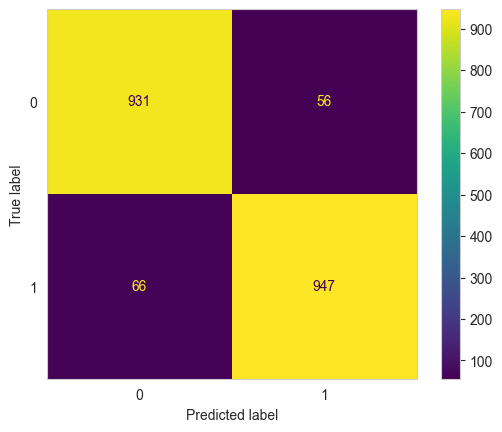

In [69]:
lr_params = [{'penalty':['l1','l2','elasticnet','none'],
           'solver': ['lbfgs','liblinear','newton-cg','sag','saga'],
           'max_iter'  : [2500,5000,10000]}]
gs_lr_clf = GridSearchCV(LogisticRegression(), param_grid=lr_params, scoring='f1', cv=5)
gs_lr_clf.fit(X_train, y_train)
print(gs_lr_clf.best_params_)
y_hat = gs_lr_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

We were not able to improve the f1 score even though a different solver was selected as best by the gridsearch. The warnings indicate that for some combinations, no solution was found. This is expected. The sklearn docs warn that not all of the penalties work with all of the solvers.

## K Nearest Neighbors ##


In [23]:
#first lest's try a naive knn classifier and see how it performs
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
print(classification_report(y_test, knn_clf.predict(X_test)))


              precision    recall  f1-score   support

        -1.0       0.94      0.94      0.94       987
         1.0       0.95      0.94      0.94      1013

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



An f1 of 94% for both classes is not bad at all. But lets try a little bit of hyperparameter tuning along with Cross Fold Validation at the same time to see if we can do a little better. Suggestions for which hyperparameters to tune and values to try came from a Medium article (Kumar, 2024)

{'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

        -1.0       0.94      0.94      0.94       987
         1.0       0.94      0.94      0.94      1013

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



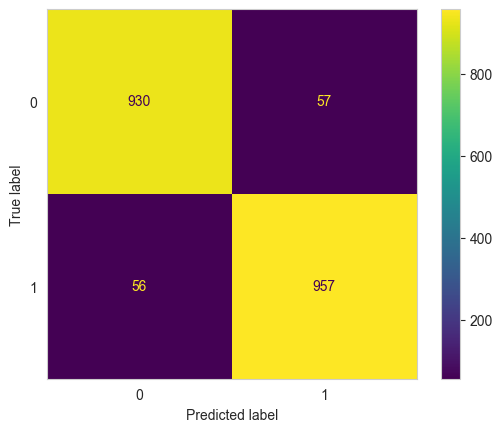

In [28]:
knn_params = [{'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
           'weights': ['uniform', 'distance'],
           'leaf_size': [10, 20, 30, 40, 50]}]
gs_knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params, scoring='f1', cv=5)
gs_knn_clf.fit(X_train, y_train)
print(gs_knn_clf.best_params_)
y_hat = gs_knn_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Unfortunately, the grid search did not provide any improvement. My naive KNN classifier had already been quite close to the optimal hyperparameters. But still 0.94 for F1 is not bad.

## Decision Tree ##


In [29]:
#first lest's try a naive decision tree classifier and see how it performs
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
print(classification_report(y_test, dt_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.97      0.96      0.97       987
         1.0       0.97      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



The F1 of 97% for a naive decision tree is almost spectacular. We will try a GridSearch for improvement through hyperparameter tuning...

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2}
              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.97       987
         1.0       0.97      0.96      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



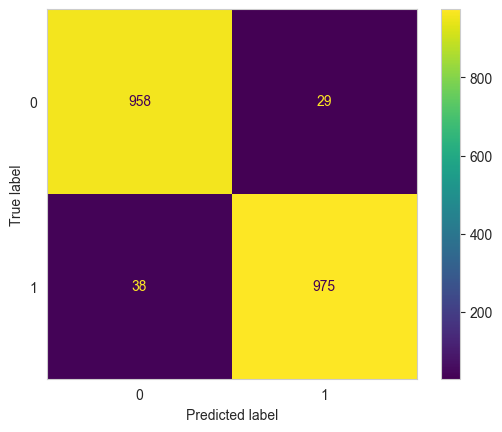

In [30]:
dt_params = [{'max_depth': [5, 10, 15, 20, 25],
           'criterion': ["gini", "entropy", "log_loss"],
           'min_samples_leaf': [1, 2, 3, 4, 5]}]
gs_dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_params, scoring='f1', cv=5)
gs_dt_clf.fit(X_train, y_train)
print(gs_dt_clf.best_params_)
y_hat = gs_dt_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

It turns out once again that a grid search did not really move the needle. Though entropy was selected as the best criterion, it did not perform noticeably better than the default of gini. I am curious to see what the decision tree looks like, so I will plot it below. The nice thing about Decision Trees is that they are so explainable.

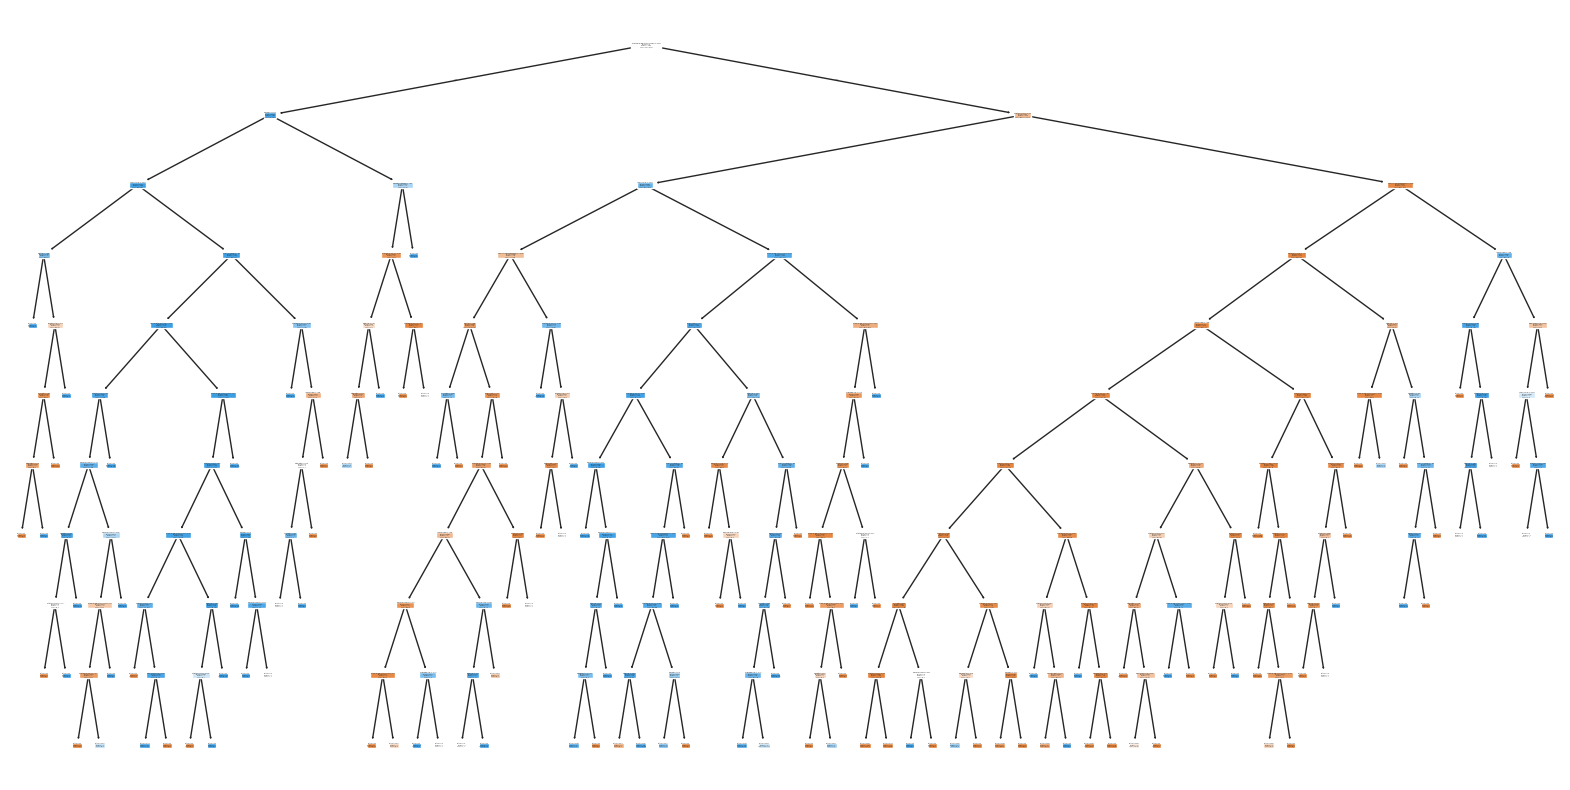

In [43]:
plt.figure(figsize=(20, 10))
plot_tree(gs_dt_clf.best_estimator_, feature_names=feature_names, filled=True)
plt.show()

The entire tree is too large to plot in a readable manner, so here is a tree with the first four levels. It is interesting to see that many of the fileds more strongly correlated with CLASS_LABEL appeared near the top of the tree. This intuitively makes sense.

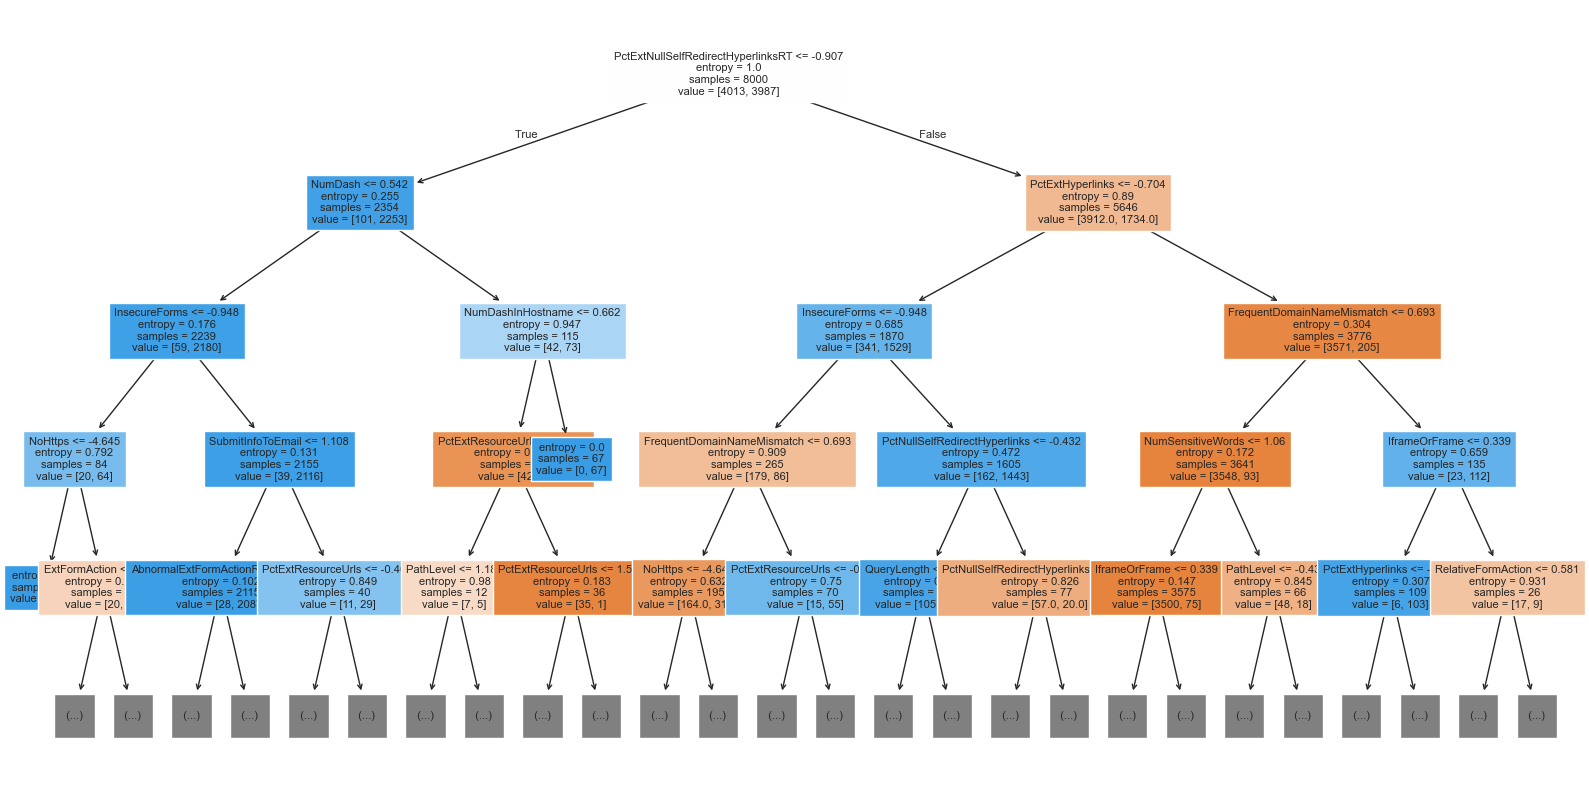

In [45]:
plt.figure(figsize=(20, 10))
plot_tree(gs_dt_clf.best_estimator_, feature_names=feature_names, filled=True, max_depth=4, fontsize=8)
plt.show()

## AdaBoosting

In [48]:
#Let's try an AdaBoostClassifier
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)
print(classification_report(y_test, ada_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96       987
         1.0       0.96      0.96      0.96      1013

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



A naive AdaBoostClassifier did pretty well with an f1 of 96%. Let's try hyperparameter tuning to improve that.

{'learning_rate': 1.0, 'n_estimators': 1000}
              precision    recall  f1-score   support

        -1.0       0.97      0.98      0.97       987
         1.0       0.98      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



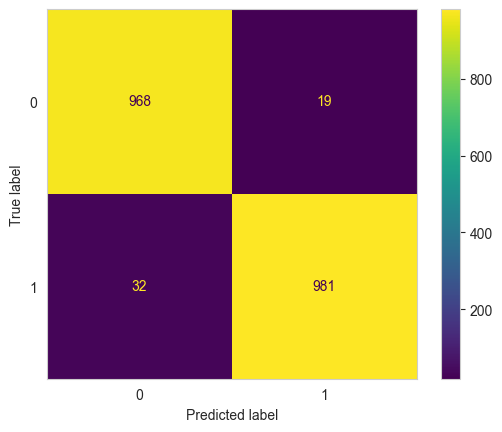

In [51]:
ada_params = [{'n_estimators': [50, 75, 100, 250, 500, 750, 1000],
           'learning_rate':  [0.5, 0.75, 1.0]}]
gs_ada_clf = GridSearchCV(AdaBoostClassifier(), param_grid=ada_params, scoring='f1', cv=5)
gs_ada_clf.fit(X_train, y_train)
print(gs_ada_clf.best_params_)
y_hat = gs_ada_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

This time the hyperparameter tuning moved the needle! That is nice to see. We improved f1 by 1% to 97%. Note that the best number of estimators was the highest (1000). I could have tried more, but I noticed the training process was becoming slow. The prediction process would also slow with a large number of estimators.

## Gradient Boosting ##


In [71]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
print(classification_report(y_test, gb_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.97      0.98      0.97       987
         1.0       0.98      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



97% f1 is another good result for the naive GradientBoostingClassifier. Let's try a GridSearch to see if we can do better. Suggestions for hyperparameters to tune and values to consider came from a GeeksforGeeks article (GeeksforGeeks, 2025d)

{'learning_rate': 0.25, 'n_estimators': 1000, 'subsample': 0.9}
              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       987
         1.0       0.99      0.98      0.99      1013

    accuracy                           0.98      2000
   macro avg       0.98      0.99      0.98      2000
weighted avg       0.99      0.98      0.99      2000



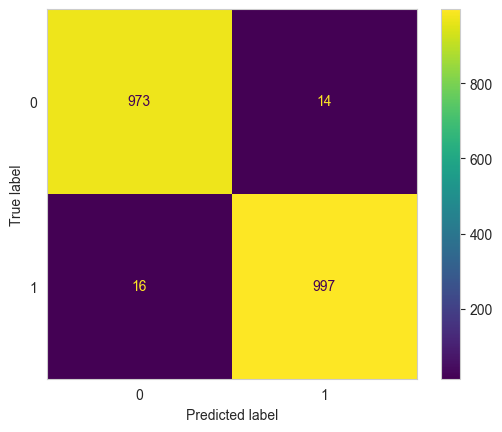

In [83]:
#WARNING: This cell takes approximately 10 minutes to run
gb_params = [{'n_estimators': [100, 500, 1000],
           'learning_rate':  [0.1, 0.25, 0.5],
              'subsample': [0.8, 0.9, 1.0]}]
gs_gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=gb_params, scoring='f1', cv=5)
gs_gb_clf.fit(X_train, y_train)
print(gs_gb_clf.best_params_)
y_hat = gs_gb_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

We achieved our **best f1 score yet** with 99% for the weighted average! It is also worth noting that our recall for both classes has reached 99%. It is interesting to note that this was achieved with the maximum number of estimators and the lowest subsample value. It is possible that better results could be achieved by increasing the estimators further and/or lowering the subsample value.

## Random Forest ##

In [70]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
print(classification_report(y_test, rf_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       987
         1.0       0.99      0.98      0.98      1013

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



The naive RandomForestClassifier did well with an f1 of 98%. Now we will try to improve that with gridsearch.

{'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 1000}
              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       987
         1.0       0.99      0.98      0.98      1013

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



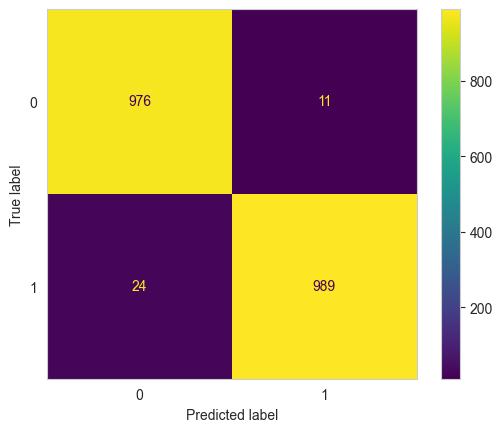

In [62]:
#WARNING; This cell takes almost 10 minutes to run!
rf_params = [{'n_estimators': [1000, 2000],
            'max_depth':  [50, 100],
            'min_samples_leaf': [1, 2, 3, 4, 5] }]
gs_rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_params, scoring='f1', cv=5)
gs_rf_clf.fit(X_train, y_train)
print(gs_rf_clf.best_params_)
y_hat = gs_rf_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

We did not see significnt improvement in the f1 score through hyperparameter tuning of the RandomForestClassifier.

## Support Vector Machine ##


In [74]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
print(classification_report(y_test, svm_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.95      0.97      0.96       987
         1.0       0.97      0.95      0.96      1013

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



A naive SVM classifier obtains an f1 score of 96%.
Suggestions for which hyperparameters to tune and what values to consider came from a Geeks for Geeks article on SVM hyperparameter tuning (GeeksforGeeks, 2025a)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97       987
         1.0       0.97      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



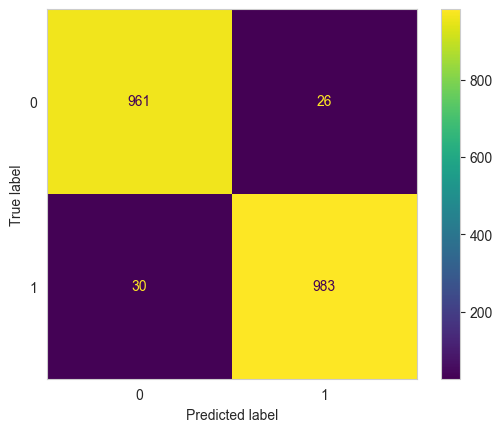

In [99]:
#WARNING - this code takes ~50 minutes to run
svm_params = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['linear', 'rbf', 'poly']}
gs_svm_clf = GridSearchCV(SVC(random_state=42), param_grid=svm_params, scoring='f1', cv=5)
gs_svm_clf.fit(X_train, y_train)
print(gs_svm_clf.best_params_)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Hyperparameter tuning gave us a small improvement in our f1 score from 96% to 97%

## Diverse Voting Ensemble ##


The paper, *PhishGuard: A Multi-Layered Ensemble Model for Optimal Phishing Website Detection* by Ovi, et. al., (Ovi, et. al., 2024) recommends an ensemble of diverse classifiers. We will try this approach using sklearn's VotingClassifier. We will use the optimal parameters discovered previously by grid search for each type of classifier.

We expect that the ensemble of diverse classifiers will perform better than any individual classifier for reasons similar to why ensembles such as AdaBoost and RandomForests perform better than a single DecisionTree.

We will use soft voting in the voting classifier as suggested by a Geeks for Geeks article (GeeksforGeeks, 2025a). This means that rather than each classifier voting a binary answer (1 or 0), they vote a probability that a sample belongs to each class. Soft voting allows the VotingClassifier to take into consideration an underlying model's confidence in the vote (how certain is the model that the sample belongs to one class or the other?).


              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97       987
         1.0       0.97      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



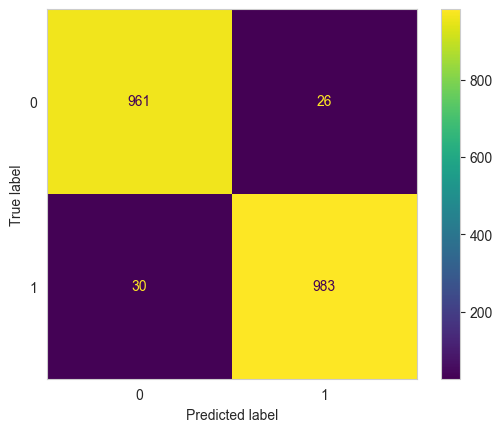

In [79]:
best_classifiers = [
    ('LR', LogisticRegression(max_iter=2500, penalty='l2', solver='liblinear', random_state=42)),
    ('KNN', KNeighborsClassifier(leaf_size=10, n_neighbors=5, weights='distance')),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2, random_state=42)),
    ('ADA', AdaBoostClassifier(learning_rate=1.0, n_estimators=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(learning_rate=0.25, n_estimators=1000, subsample=0.8, random_state=42)),
    ('RF', RandomForestClassifier(max_depth=50, min_samples_leaf=1, n_estimators=1000, random_state=42)),
    ('SVC', SVC(C=100, gamma=0.01, kernel='rbf', random_state=42))
]

voting_clf = VotingClassifier(estimators=best_classifiers, voting='soft')
voting_clf.fit(X_train, y_train)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

The voting classifier **DID NOT** outperform the best classifier included in the voting ensemble. This is initially surprising to me. But perhaps it should be expected because we included several classifiers that achieved only 94% f1 score. Perhaps by removing these low performing classifiers from the voting ensemble, we can do better.

              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97       987
         1.0       0.97      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



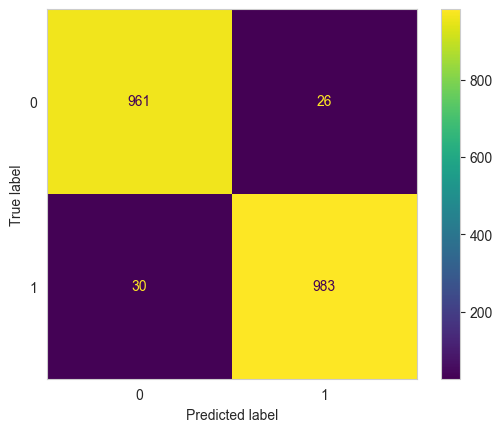

In [80]:
best_classifiers = [
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2, random_state=42)),
    ('ADA', AdaBoostClassifier(learning_rate=1.0, n_estimators=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(learning_rate=0.25, n_estimators=1000, subsample=0.8, random_state=42)),
    ('RF', RandomForestClassifier(max_depth=50, min_samples_leaf=1, n_estimators=1000, random_state=42)),
    ('SVC', SVC(C=100, gamma=0.01, kernel='rbf', random_state=42))
]

voting_clf = VotingClassifier(estimators=best_classifiers, voting='soft')
voting_clf.fit(X_train, y_train)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Removing the worst classifiers from the ensemble has a negligable effect. The performance of the ensemble is still slightly worse than an optimized gradient boost classifier or random forest classifier. Next we will try hard voting.

              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97       987
         1.0       0.97      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



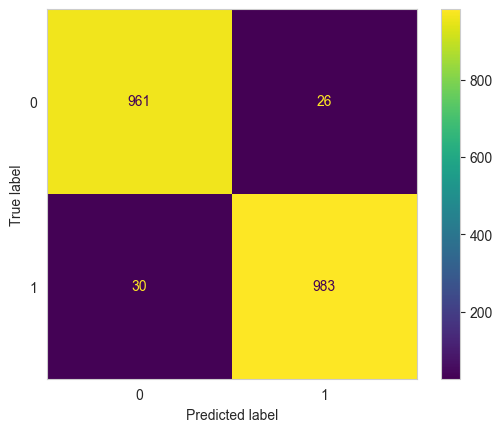

In [81]:
best_classifiers = [
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2, random_state=42)),
    ('ADA', AdaBoostClassifier(learning_rate=1.0, n_estimators=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(learning_rate=0.25, n_estimators=1000, subsample=0.8, random_state=42)),
    ('RF', RandomForestClassifier(max_depth=50, min_samples_leaf=1, n_estimators=1000, random_state=42)),
    ('SVC', SVC(C=100, gamma=0.01, kernel='rbf', random_state=42))
]

voting_clf = VotingClassifier(estimators=best_classifiers, voting='hard')
voting_clf.fit(X_train, y_train)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Hard voting did not imporve the outcome. We must conclude that for this data set, the very best performing classifiers outperform a voting ensemble that includes less accurate classifiers.

# Result #

The best f1 score and the fewest misclassified examples were achieved with a **GradientBoostingClassifier** after conducting a grid search for the optimal hyperparameters. That optimized classifier and it's results are shown below. We achieved a **99% f1 score, accuracy, and recall for all classes**. Only 27 of 2000 test examples were misclassified.

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.99       987
         1.0       0.99      0.99      0.99      1013

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



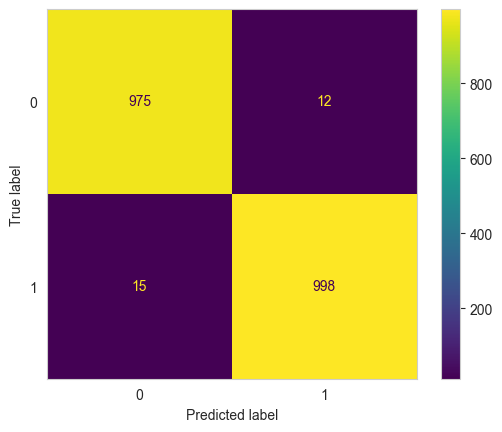

In [82]:
best_clf = GradientBoostingClassifier(learning_rate=0.25, n_estimators=1000, subsample=0.8, random_state=42)
best_clf.fit(X_train, y_train)
y_hat = best_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

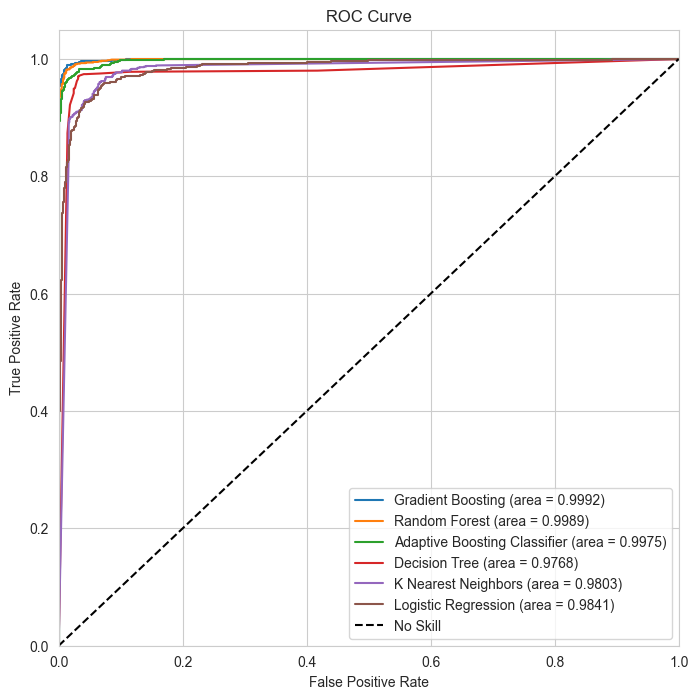

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, gs_lr_clf.predict_proba(X_test)[:, 1])
lr_roc_auc = auc(lr_fpr, lr_tpr)
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, gs_knn_clf.predict_proba(X_test)[:, 1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, gs_dt_clf.predict_proba(X_test)[:, 1])
dt_roc_auc = auc(dt_fpr, dt_tpr)
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, gs_ada_clf.predict_proba(X_test)[:, 1])
ada_roc_auc = auc(ada_fpr, ada_tpr)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, gs_rf_clf.predict_proba(X_test)[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.4f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.4f)' % rf_roc_auc)
plt.plot(ada_fpr, ada_tpr, label='Adaptive Boosting Classifier (area = %0.4f)' % ada_roc_auc)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.4f)' % dt_roc_auc)
plt.plot(knn_fpr, knn_tpr, label='K Nearest Neighbors (area = %0.4f)' % knn_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (area = %0.4f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

As a final confirmation of our results, we have compared the Receiver Operating Characteristics (ROC) curves for the various tuned models. We can see that Gradient Boosting remains the best performer with Random Forest coming in a close second place.

# Discussion and Conclusion #


Examination of the initial data set showed that none of the features were strongly correlated with the class label. Several features were weakly (0.25-0.50) or moderately (0.50-0.75) correlated with the class label. These include RequestDomainNameMismatch (0.464), InsecureForms (0.31), SubmitInfoToEmail (-0.358), PctExtNullSelfRedirectHyperlinksRT (-0.541), NumDots (0.294), NumDash (-0.372). But the majority of features are not correlated with the class label (<0.25). The lack of obvious correlation makes this a very interesting problem for machine learning. It is not reasonable to expect a human to discern patterns in this data that can be reliably used to predict the class label.

We used a variety of machine learning classifiers on this data set and tuned hyperparameters for each of the classifiers. We also tried a voting classifier that contained the tuned versions of each individual model. The f1 score for each classifier before and after tuning are shown in the table below.

| Classifier | untuned f1 score | tuned f1 score |
| ---------- | ---------------- |----------------|
| LogisticRegression | 0.94     | 0.94           |
| KNeighborsClassifier | 0.94   | 0.94           |
| DecisionTreeClassifier | 0.97 | 0.97           |
| AdaBoostClassifier | 0.96     | 0.97           |
| GradientBoostingClassifier | 0.97 | 0.99       |
| RandomForestClassifier | 0.98 | 0.98           |
| SVC       | 0.96              | 0.97           |
| VotingClassifier | N/A        | 0.97           |

We can conclude a few things from these results. First is that the default hyperparameters for the models tested were well-suited to this dataset. Prior to hyperparameter tuning, f1 scores ranged from 0.94-0.98. After hyperparameter tuning, f1 scores ranged from 0.94 to 0.99. Only a few models saw their f1 score increase enough to change the results on a classification report (which is rounded to two significant digits). These models were AdaBoostClassifier, GradientBoostingClassifier, and SVC.

The VotingClassifier did not produce results better than the best individual classifier. This may be because ensembles tend to work best when averaging many weak learners. All of these models were strong learners and we used only 7 models. It makes sense intuitively that the average of the results of a small number of models will be less than the results of the best model.

The **best classifier** found was **GradientBoostingClassifier** with a learning_rate=0.25, n_estimators=1000, and subsample=0.8. with this classifier, we achieved a **99% f1 score, accuracy, and recall for all classes**. Only 27 of 2000 test examples were misclassified. It is worth noting that an n_estimators of 1000 was the largest value provided in the grid search parameters. Similarly, a subsample of 0.8 was the smallest subsample provided in the parameters. **Further investigation is warranted** into whether increasing the number of estimators beyond 1000 and/or reducing the subsample below 0.8 can provide an increased f1 score. Increasing the number of estimators must be balanced with the increase in training and prediction time that comes with more estimators and with the possibility that more estimators will lead to overfitting.



# Citations #


GeeksforGeeks. (2025a, July 12). Voting classifier using Sklearn - ml. https://www.geeksforgeeks.org/machine-learning/ml-voting-classifier-using-sklearn/

GeeksforGeeks. (2025b, July 23). How to optimize logistic regression performance. https://www.geeksforgeeks.org/machine-learning/how-to-optimize-logistic-regression-performance/

GeeksforGeeks. (2025c, September 2). SVM hyperparameter tuning using GRIDSEARCHCV - ml. https://www.geeksforgeeks.org/machine-learning/svm-hyperparameter-tuning-using-gridsearchcv-ml/

GeeksforGeeks. (2025d, September 5). How to tune hyperparameters in Gradient Boosting Algorithm. https://www.geeksforgeeks.org/machine-learning/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/

Kumar, R. (2024, September 21). GRIDSEARCHCV simplified: Hyperparameter tuning for newbies. Medium. https://medium.com/@hereisranjan/gridsearchcv-simplified-hyperparameter-tuning-for-newbies-36a50c267d31

Ovi, M. S. I., Rahman, Md. H., & Hossain, M. A. (2024, September 29). PhishGuard: A multi-layered ensemble model for optimal phishing website detection. arXiv.org. https://arxiv.org/abs/2409.19825

Ovi, Sultanul. (2025). *Phishing Website Detection Datasets.* Kaggle. https://www.kaggle.com/datasets/mdsultanulislamovi/phishing-website-detection-datasets/data?select=dataset6.csv

Yarbrough, B. C. (n.d.). Federal Bureau of Investigation Internet Crime Report 2024. Internet Crime Complaint Center. https://www.ic3.gov/AnnualReport/Reports/2024_IC3Report.pdf



